# Miller age

In [1]:
%load_ext autoreload
%autoreload 2
# # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/Users/kemalinecik/git_nosync/tardis")
import tardis
tardis.config = tardis.config_local
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/Users/kemalinecik/git_nosync/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
ood_seed = 1
num_ood = 1

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

def adata_ood_creator(adata, seed, size):
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    adata.obs["age_continuous"] = adata.obs["age"].astype(float)
    df = adata.obs.groupby(["cell_type", "age"]).size()
    df2 = adata.obs.groupby(["cell_type"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 350]
    rng = np.random.default_rng(seed=seed)
    random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    choices = [availables[i] for i in random_choices]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Hub cells', '15.0'), 308)

Removed datapoint: 308


In [6]:
adata

AnnData object with n_obs × n_vars = 7097 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [7]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_age_ood-seed-{ood_seed}"
)

In [8]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [9]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [10]:
warmup_epoch_range = [12, 48]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=32, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=1000,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=True,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    ),
    limit_train_batches=0.5, 
    limit_val_batches=0.5,
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

vae.save(
    dir_path,
    overwrite=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if yo

Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 558,2070,2424,626
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 264,294,506,94,1470,1496,928,626
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/1000:   0%|          | 1/1000 [00:01<30:04,  1.81s/it]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 149,546,581,143
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `integration_donor` for `validation` set. Number of elements in each group: 62,87,127,24,395,370,211,143
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 359/1000:  36%|███▌      | 358/1000 [09:18<16:05,  1.50s/it, v_num=1, total_loss_train=783, kl_local_train=34.8, tardis_age_0_train=16.4, tardis_age_1_train=5.69, tardis_integration_donor_0_train=17.3, tardis_integration_donor_1_train=5.05]

/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [11]:
batch_size_vae_metrics = 512
vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_train_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_train_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    "r2_validation_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    "r2_validation_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

reconstruction_error -738.4520638121742
elbo -772.5433349609375
r2_train 0.8821396895179463
r2_train_deg_20 -0.6740113904311351
r2_train_deg_50 0.7368857523898668
r2_validation 0.8701907976537938
r2_validation_deg_20 0.7173519343181556
r2_validation_deg_50 0.5735041933501623


In [15]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [18]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
3             18.0    3005
2             15.0    2616
4             21.0     769
1             11.5     707
dtype: int64

In [12]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

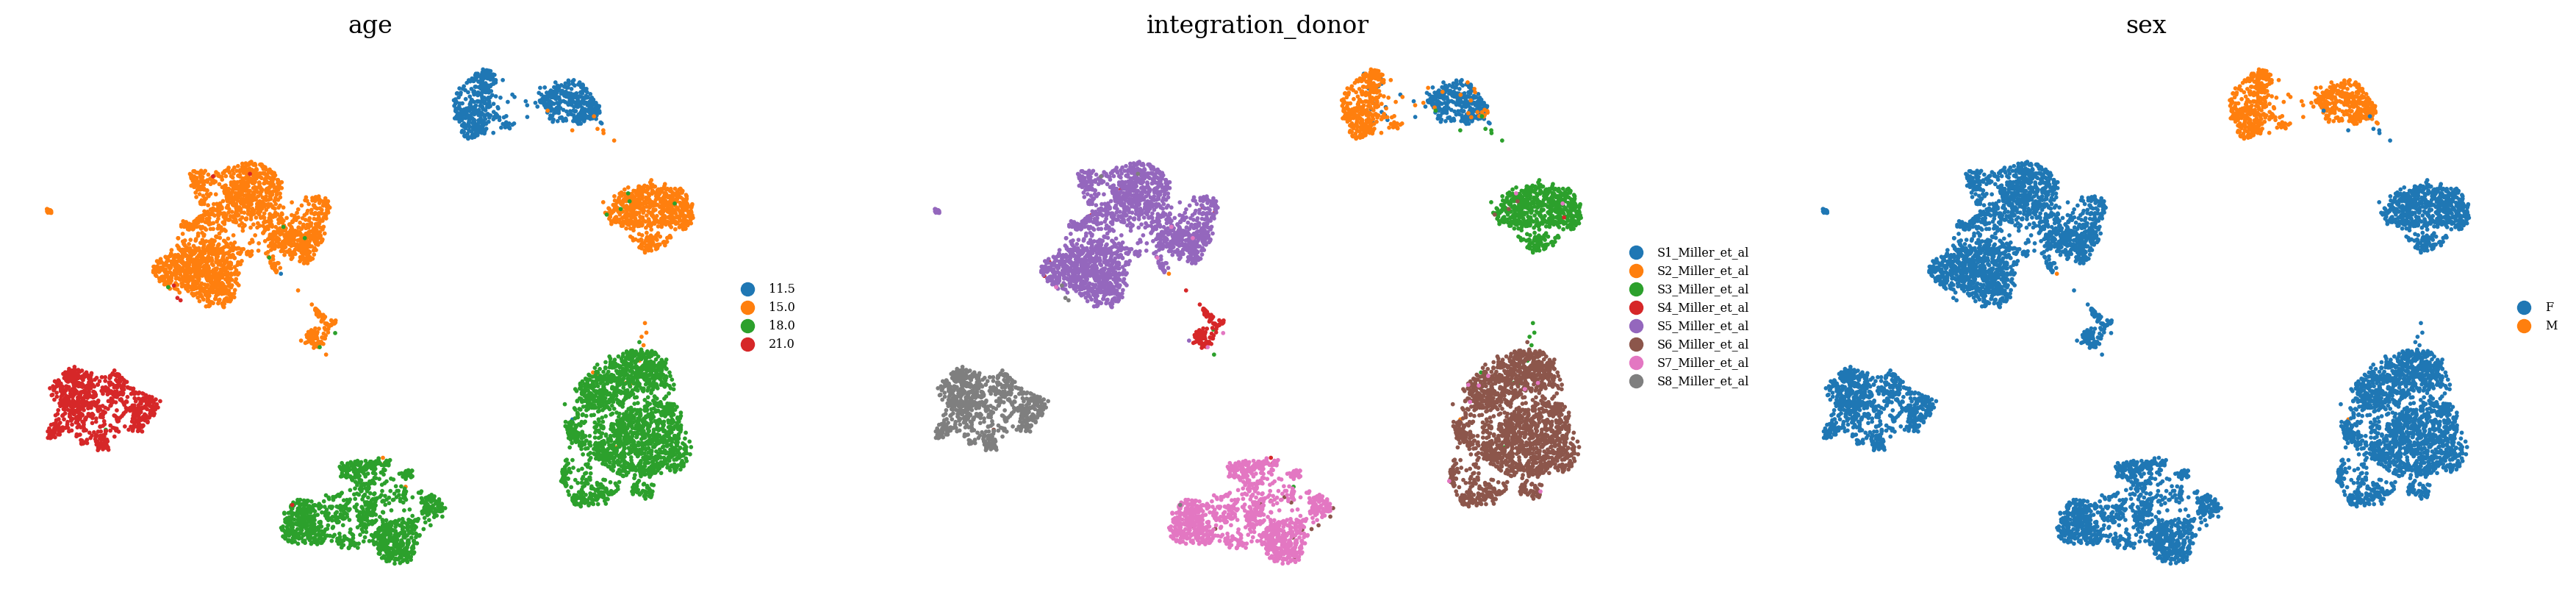

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [15]:
from tardis._disentanglementmanager import DisentanglementManager as DM

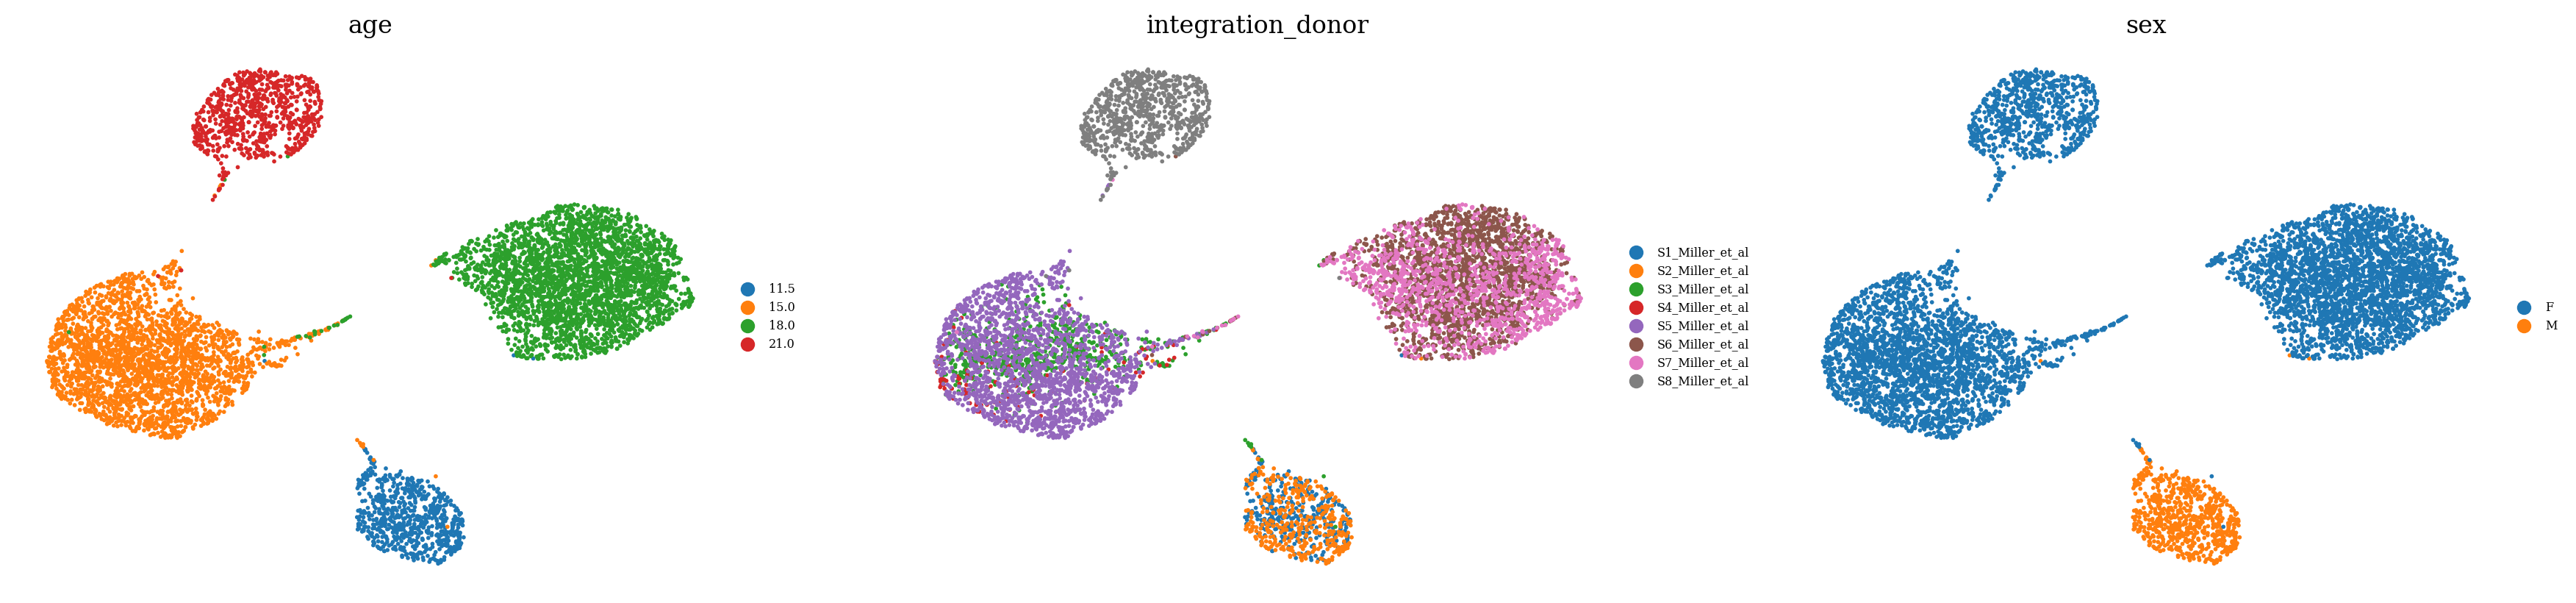

In [16]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

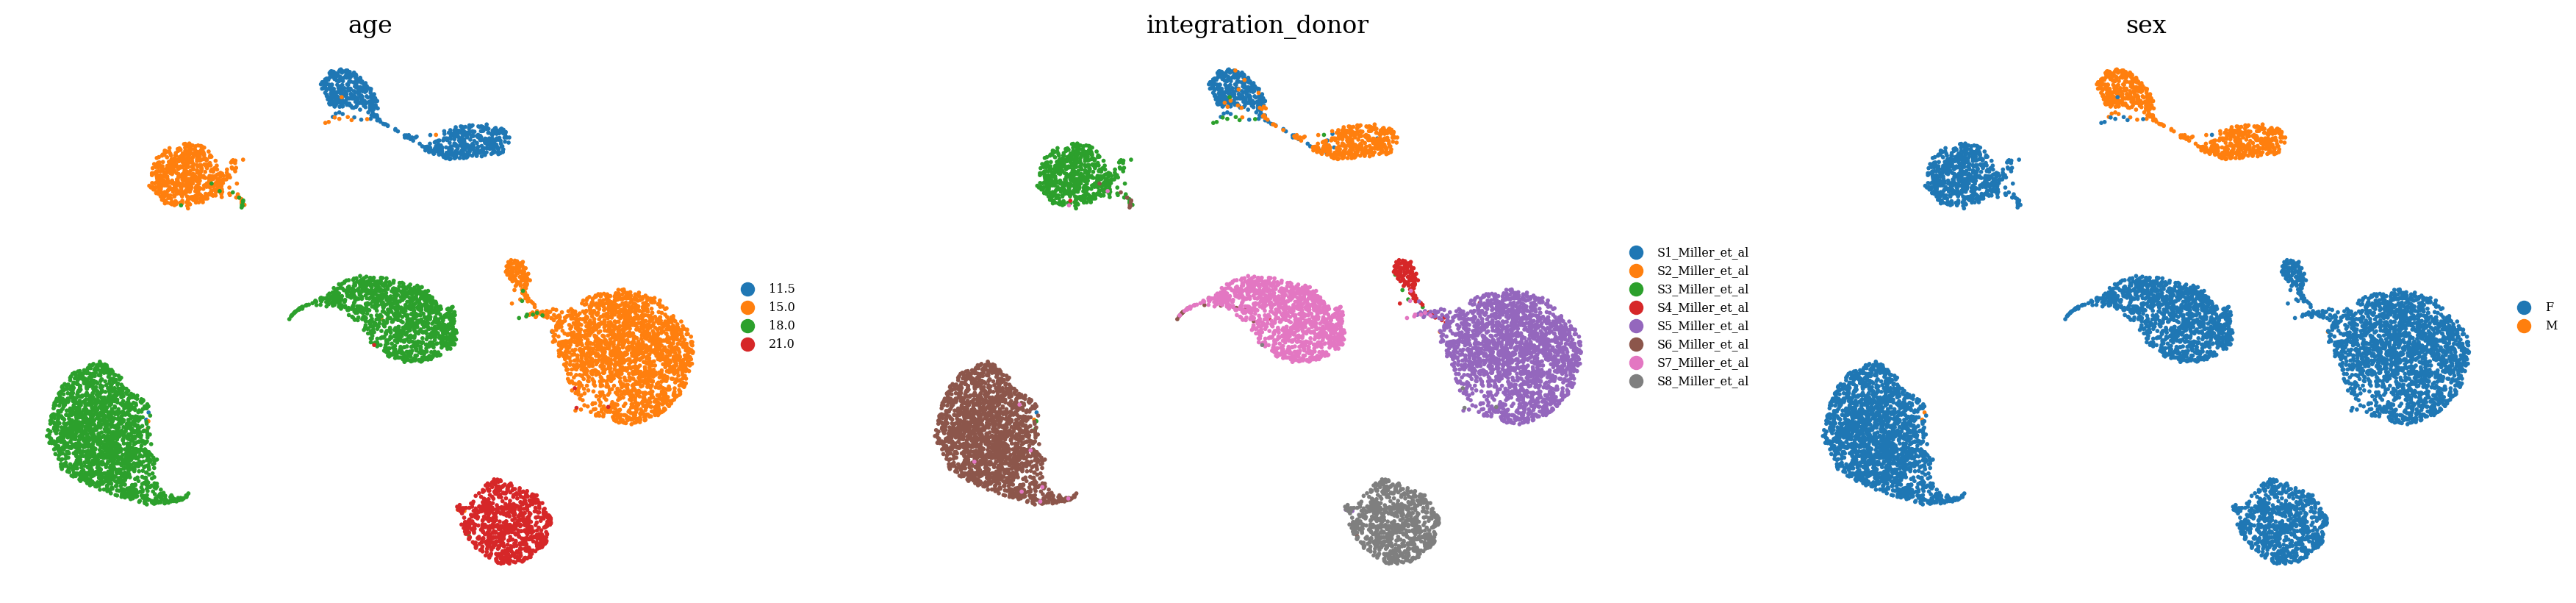

In [17]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [25]:
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood, n_neighbors = 30)
sc.tl.umap(latent_ood)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [26]:
from scanpy.tools import Ingest as sc_Ingest
def label_transfer(
    reference_embeddings: ad.AnnData,
    query_embeddings: ad.AnnData,
    cluster_list: list[str],
    neighbors_count: int,
):
    # Compute a joint neighbor graph for reference and query embeddings
    joint_graph = sc_Ingest(reference_embeddings)
    joint_graph.fit(query_embeddings)
    joint_graph.neighbors(k=neighbors_count)

    # Calculate distances to top neighbors_count neighbors for each cell and store indices
    top_neighbor_distances, top_neighbor_indices = joint_graph._distances, joint_graph._indices

    # Transform distances with Gaussian kernel
    distance_stds = np.std(top_neighbor_distances, axis=1)
    distance_stds = (2.0 / distance_stds) ** 2
    distance_stds = distance_stds.reshape(-1, 1)
    transformed_distances = np.exp(-np.true_divide(top_neighbor_distances, distance_stds))

    # Normalize transformed distances so that they sum to 1
    normalized_weights = transformed_distances / np.sum(transformed_distances, axis=1, keepdims=True)

    # Initialize empty series to store predicted labels and uncertainties for each query cell
    cell_uncertainties = pd.Series(index=query_embeddings.obs_names, dtype="float64")
    predicted_labels = pd.Series(index=query_embeddings.obs_names, dtype="object")

    # Iterate through query cells
    for cluster in cluster_list:
        train_labels = reference_embeddings.obs[cluster].values
        for index in range(len(normalized_weights)):
            # Store cell types present among neighbors in reference
            unique_cell_types = np.unique(train_labels[top_neighbor_indices[index]])

            # Store best label and corresponding probability
            best_cell_type, best_probability = None, 0.0

            # Iterate through all cell types present among the cell's neighbors
            for label in unique_cell_types:
                prob = normalized_weights[index, train_labels[top_neighbor_indices[index]] == label].sum()
                if best_probability < prob:
                    best_probability = prob
                    best_cell_type = label
            else:
                final_label = best_cell_type

            # Store best label and corresponding uncertainty
            cell_uncertainties.iloc[index] = max(1 - best_probability, 0)
            predicted_labels.iloc[index] = final_label

        query_embeddings.obs[f"transf_{cluster}"] = predicted_labels
        query_embeddings.obs[f"transf_{cluster}_unc"] = cell_uncertainties

In [27]:
latent_ood

AnnData object with n_obs × n_vars = 308 × 8
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'ood', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [28]:
label_transfer(latent, latent_ood, cluster_list=["age"], neighbors_count=30)

/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [29]:
latent_ood.obs

,sample_ID,organ,age,cell_type,sex,sex_inferred,concatenated_integration_covariates,integration_donor,integration_biological_unit,integration_sample_status,integration_library_platform_coarse,n_genes,ood,_scvi_batch,_scvi_labels,transf_age,transf_age_unc
Miller_S3_AAACGGGTCCCACTTG,S3,Lung,15.0,Hub cells,F,F,S3_Miller_et_al_Cell_Fresh_3GEX,S3_Miller_et_al,Cell,Fresh,3GEX,69,1,2,3,15.0,1.999437e-01
Miller_S3_AACTCAGGTGTGCCTG,S3,Lung,15.0,Hub cells,F,F,S3_Miller_et_al_Cell_Fresh_3GEX,S3_Miller_et_al,Cell,Fresh,3GEX,225,1,2,3,15.0,5.960464e-08
Miller_S3_ACTGCTCAGTACACCT,S3,Lung,15.0,Hub cells,F,F,S3_Miller_et_al_Cell_Fresh_3GEX,S3_Miller_et_al,Cell,Fresh,3GEX,75,1,2,3,15.0,3.333473e-02
Miller_S3_AGCGTATAGGTTACCT,S3,Lung,15.0,Hub cells,F,F,S3_Miller_et_al_Cell_Fresh_3GEX,S3_Miller_et_al,Cell,Fresh,3GEX,150,1,2,3,15.0,1.664073e-01
Miller_S3_AGTCTTTCATTCCTCG,S3,Lung,15.0,Hub cells,F,F,S3_Miller_et_al_Cell_Fresh_3GEX,S3_Miller_et_al,Cell,Fresh,3GEX,169,1,2,3,15.0,1.335979e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Miller_S5_TTCGGTCTCCTAGTGA,S5,Lung,15.0,Hub cells,F,F,S5_Miller_et_al_Cell_Fresh_3GEX,S5_Miller_et_al,Cell,Fresh,3GEX,203,1,4,3,15.0,2.667861e-01
Miller_S5_TTGAACGTCTGTCCGT,S5,Lung,15.0,Hub cells,F,F,S5_Miller_et_al_Cell_Fresh_3GEX,S5_Miller_et_al,Cell,Fresh,3GEX,164,1,4,3,15.0,1.331683e-01
Miller_S5_TTGCGTCTCTGCAAGT,S5,Lung,15.0,Hub cells,F,F,S5_Miller_et_al_Cell_Fresh_3GEX,S5_Miller_et_al,Cell,Fresh,3GEX,134,1,4,3,15.0,3.326988e-02
Miller_S5_TTGGAACCATCCTAGA,S5,Lung,15.0,Hub cells,F,F,S5_Miller_et_al_Cell_Fresh_3GEX,S5_Miller_et_al,Cell,Fresh,3GEX,109,1,4,3,15.0,1.665260e-01


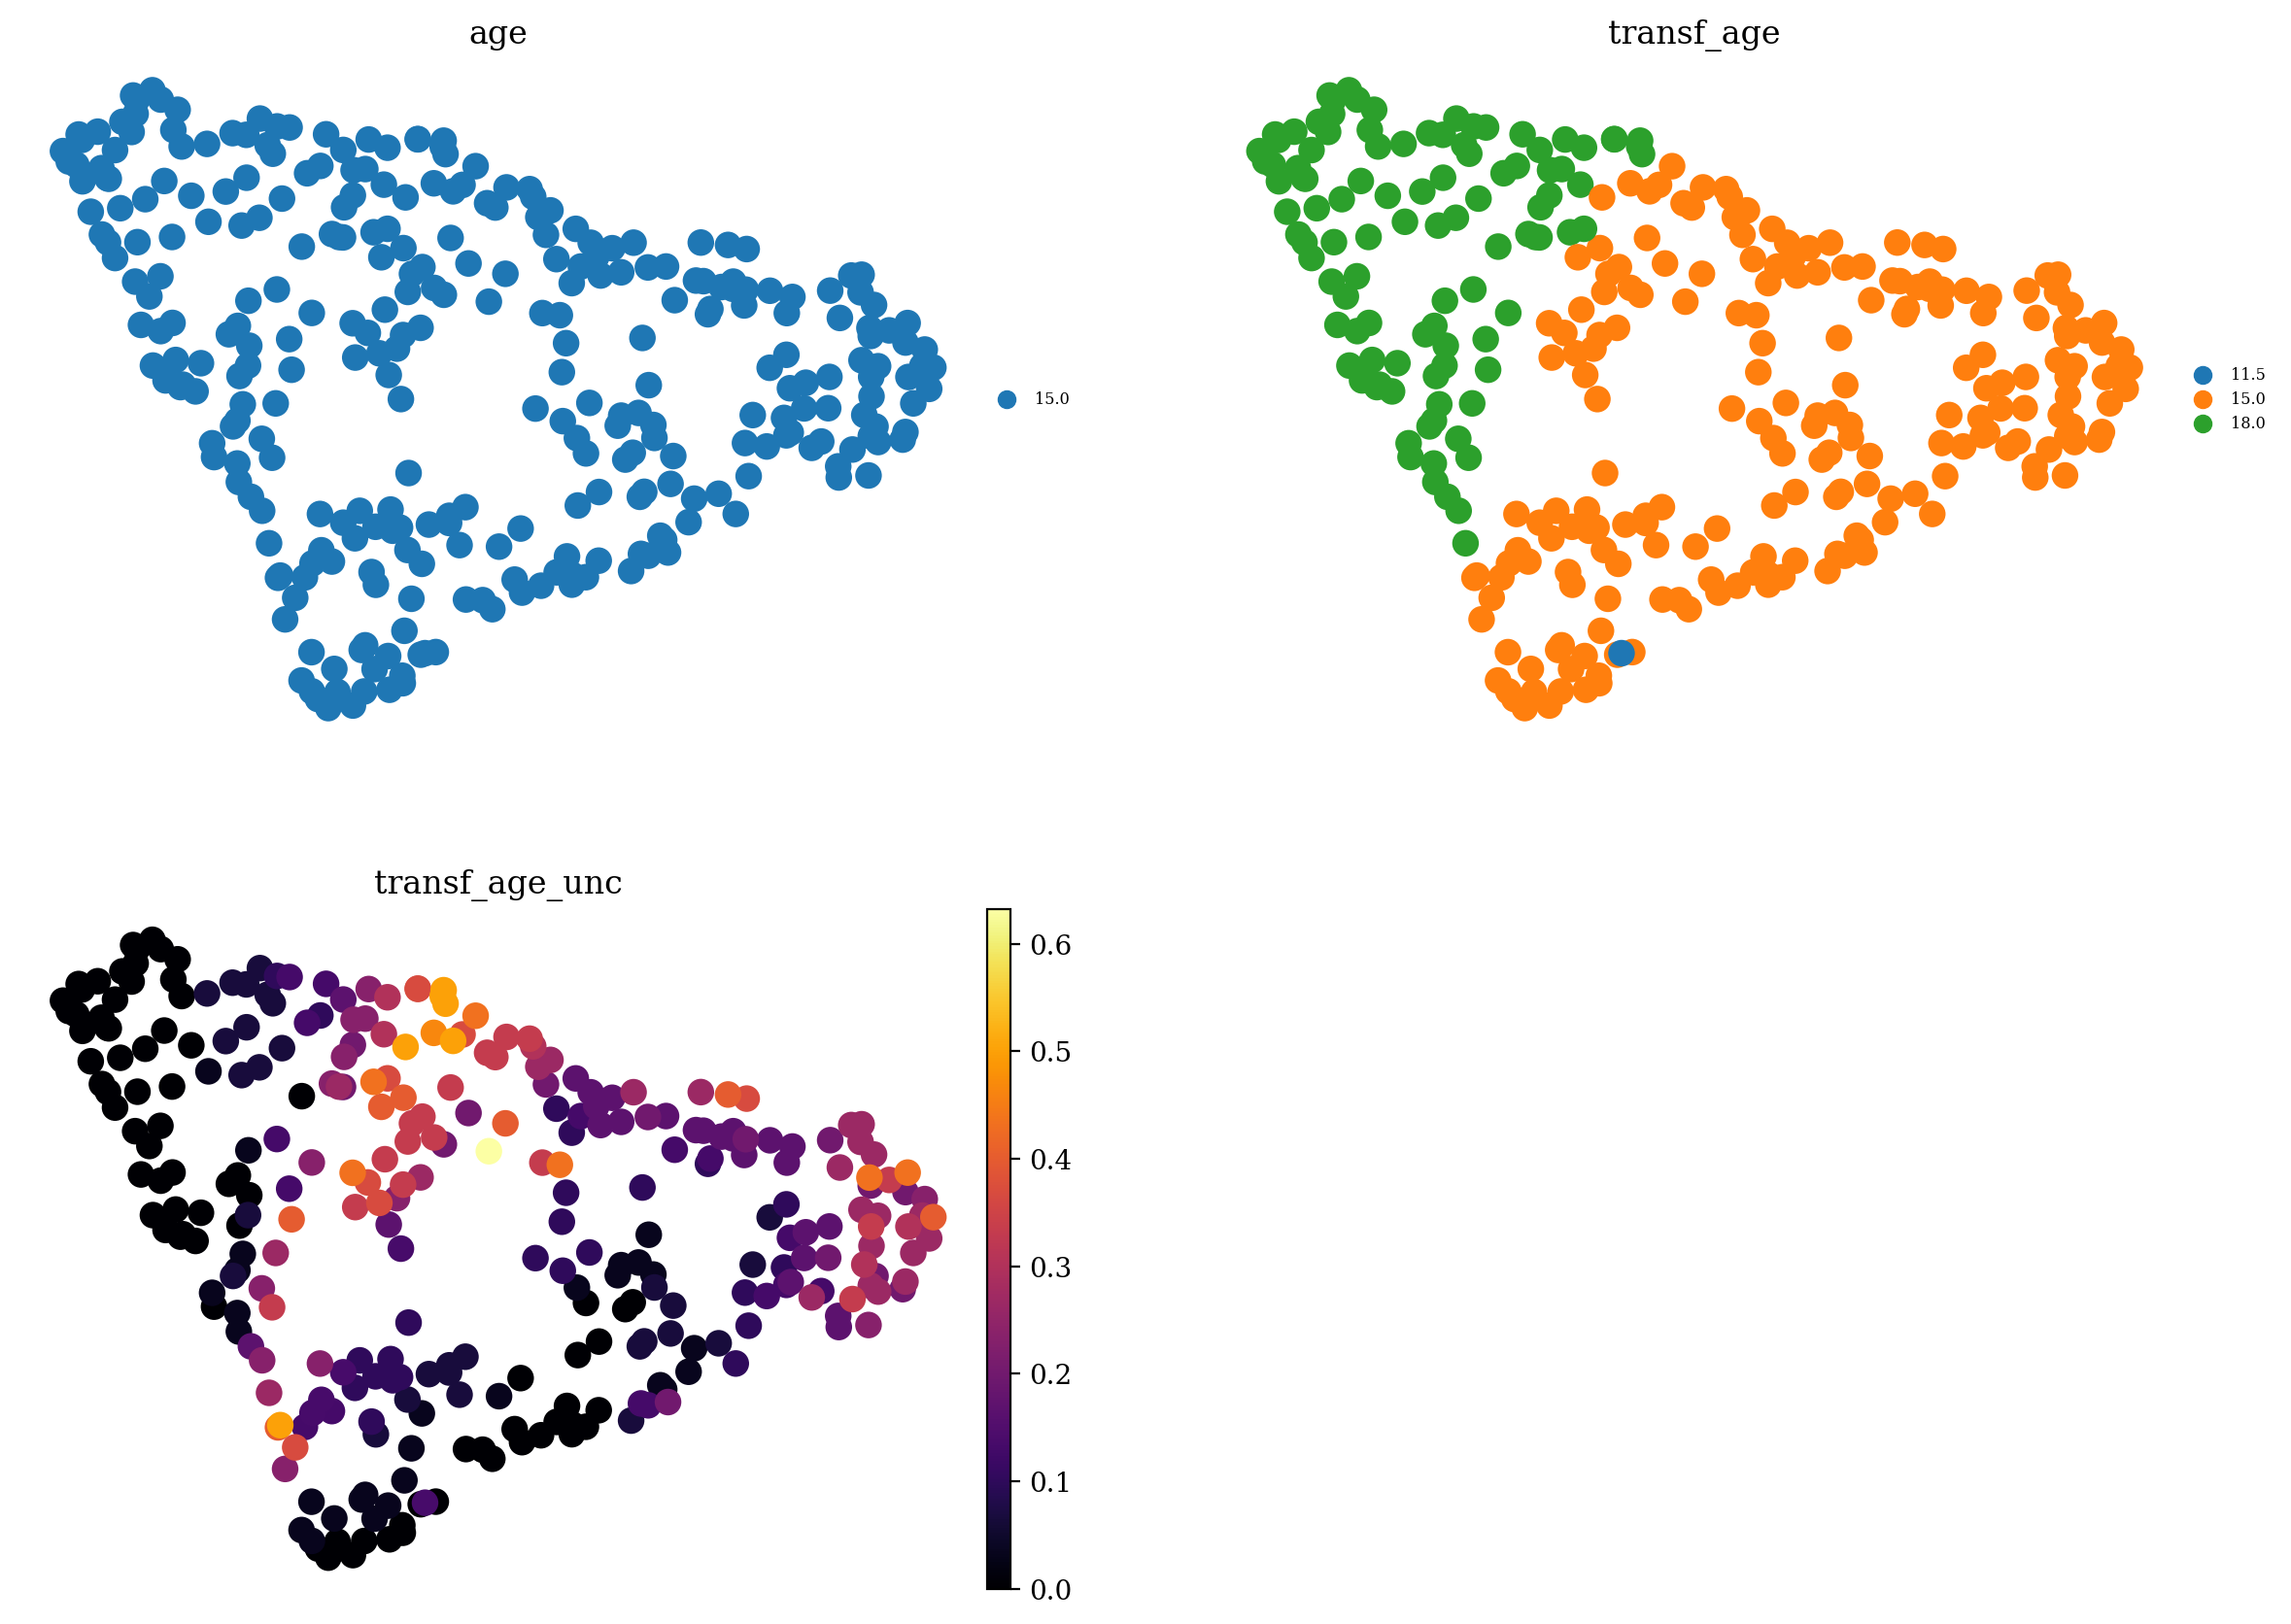

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=["age", "transf_age", "transf_age_unc"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [34]:
(latent_ood.obs["transf_age"].astype(str) == latent_ood.obs["age"].astype(str)).sum() / len(latent_ood.obs["transf_age"]) 

0.6623376623376623